In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import pandas as pd
import scipy.sparse as ssp
from functools import lru_cache
from tqdm import tqdm, trange
import xgboost as xgb 
from sklearn.model_selection import GroupKFold
import time
import matplotlib.pyplot as plt

In [25]:
merged_candidates_feature_test_path = '/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/XGBoost/candidates_phase2/merged_candidates_150_test_feature.parquet'
merged_candidates_feature_path = '/root/autodl-tmp/xiaolong/WorkSpace/Amazon-KDDCUP-23/XGBoost/candidates_phase2/merged_candidates_150_feature.parquet'

In [26]:
@lru_cache(maxsize=1)
def read_merged_candidates_feature_test():
    return pd.read_parquet(merged_candidates_feature_test_path, engine='pyarrow')

@lru_cache(maxsize=1)
def read_merged_candidates_feature():
    return pd.read_parquet(merged_candidates_feature_path, engine='pyarrow')

In [27]:
test_candidates = read_merged_candidates_feature_test()

In [28]:
len(test_candidates)

96556035

In [29]:
test_candidates.query('sess_id==50505').sort_values(by=['sasrec_scores_3'], ascending=False)[:25]

,sess_id,sess_locale,product,sasrec_scores_2,normalized_sasrec_scores_2,sasrec_scores_3,normalized_sasrec_scores_3,sess_avg_price,product_price,seqmlp_scores,...,lyx_u2i_mbart_mean_score,normalized_lyx_u2i_mbart_mean_score,lyx_lknn_i2i_score,lyx_lknn_u2i_score,normalized_lyx_lknn_i2i_score,normalized_lyx_lknn_u2i_score,lyx_gru4rec_i2i_score,lyx_gru4rec_u2i_score,normalized_lyx_gru4rec_i2i_score,normalized_lyx_gru4rec_u2i_score
15164006,50505,DE,B08X4LQ154,18.314672,0.352785,17.348755,0.278302,19.99,13.990000,18.214016,...,21.156460,0.049599,27.258099,17.186304,0.335325,0.239221,16.160906,14.841549,0.131307,0.093758
15164007,50505,DE,B08X4MBB7V,17.557625,0.165473,16.810863,0.162522,19.99,18.990000,17.176191,...,20.975506,0.041389,27.037773,16.775743,0.269017,0.158670,15.976009,14.682376,0.109141,0.079961
15163994,50505,DE,B08VZCB5R2,16.608877,0.064076,15.693432,0.053164,19.99,18.900000,17.157967,...,15.836541,0.000243,24.937435,15.594033,0.032932,0.048673,15.885342,14.158883,0.099681,0.047373
15164063,50505,DE,B09N7JX75C,15.248867,0.016446,15.150209,0.030882,19.99,27.900000,15.513212,...,19.382866,0.008418,24.445797,14.906426,0.020142,0.024472,14.309284,14.203713,0.020613,0.049545
15164008,50505,DE,B08X4N9FZ6,15.803396,0.028634,15.125531,0.030129,19.99,24.990000,16.144485,...,21.156517,0.049602,24.951065,15.341291,0.033384,0.037802,14.667064,12.787847,0.029480,0.012025
15164094,50505,DE,B0B4DXCCH3,15.453727,0.020184,15.120103,0.029966,19.99,49.990002,14.984374,...,20.562843,0.027395,24.431572,14.736400,0.019857,0.020645,14.546407,13.256327,0.026129,0.019211
15163990,50505,DE,B08T97QH84,15.124459,0.014522,14.975269,0.025925,19.99,29.900000,15.065176,...,18.277924,0.002788,23.495848,14.387380,0.007790,0.014563,14.010790,12.968899,0.015293,0.014412
15164107,50505,DE,B0BHS7BT4X,15.885178,0.031074,14.808543,0.021944,19.99,15.990000,16.390392,...,16.770262,0.000617,24.633696,14.776005,0.024305,0.021479,13.562132,13.999355,0.009765,0.040387
15164084,50505,DE,B0B15MX2HM,15.456314,0.020237,14.740116,0.020493,19.99,36.761604,15.940210,...,17.177242,0.000928,24.075304,14.974969,0.013906,0.026208,14.514532,14.599980,0.025309,0.073637
15164093,50505,DE,B0B4DWJMX3,14.962668,0.012352,14.723795,0.020161,19.99,39.990002,14.313828,...,20.881485,0.037675,24.504841,14.860503,0.021367,0.023373,14.696177,13.656396,0.030350,0.028662


In [30]:
test_candidates['sess_locale'] = test_candidates['sess_locale'].astype('category')

In [31]:
# FEATURES = ['product_freq', 'product_price',
#              'sasrec_scores_2', 'normalized_sasrec_scores_2', 
#              'sasrec_scores_3', 'normalized_sasrec_scores_3', 
#              'gru4rec_scores_2', 'normalized_gru4rec_scores_2',
#              'seqmlp_scores', 'normalized_seqmlp_scores',
#              'narm_scores', 'normalized_narm_scores',
#              'sasrec_feat_scores_3', 'normalized_sasrec_feat_scores_3',
#              'sasrec_cat_scores_3', 'normalized_sasrec_cat_scores_3',
#              'gru4rec_feat_scores_2', 'normalized_gru4rec_feat_scores_2',
#              'narm_feat_scores', 'normalized_narm_feat_scores',
#              'all_items_co_graph_count_0', 'normalized_all_items_co_graph_count_0',
#              'all_items_co_graph_count_1', 'normalized_all_items_co_graph_count_1',
#              'all_items_co_graph_count_2', 'normalized_all_items_co_graph_count_2',
#              'co_graph_counts_0', 'normalized_co_graph_counts_0',
#              'co_graph_counts_1', 'normalized_co_graph_counts_1',
#              'co_graph_counts_2', 'normalized_co_graph_counts_2',
#              'desc_BM25_scores', 'title_BM25_scores',
#              'roberta_scores', 'normalized_roberta_scores',
#              'text_bert_scores', 'normalized_text_bert_scores',
#              'title_bert_scores', 'normalized_title_bert_scores',
#              'w2v_l1_score', 'w2v_l2_score', 'w2v_l3_score',
#              'sasrec_duorec_score', 'normalized_sasrec_duorec_score',
#              'next_freq_',
#              'sess_avg_price', 'sess_locale', 
#              'lyx_itemcf_score', 'lyx_usercf_score', 
#              'lyx_i2i_base_l1_score', 'lyx_i2i_base_l2_score', 'lyx_i2i_base_l3_score', 
#              'normalized_lyx_i2i_base_l1_score', 'normalized_lyx_i2i_base_l2_score', 'normalized_lyx_i2i_base_l3_score',
#              'lyx_u2i_mbart_mean_score', 'normalized_lyx_u2i_mbart_mean_score', 
#              'lyx_lknn_i2i_score', 'lyx_lknn_u2i_score', 
#              'normalized_lyx_lknn_i2i_score', 'normalized_lyx_lknn_u2i_score',
#              'lyx_gru4rec_i2i_score', 'lyx_gru4rec_u2i_score',
#              'normalized_lyx_gru4rec_i2i_score', 'normalized_lyx_gru4rec_u2i_score']
# FEATURES.sort()
# FOLDS = 5
# TOPK = 100
# ckpt_list = []
# for i in range(FOLDS):
#     ckpt_list.append(f'./ckpt/XGB_2023_06_06_23_42_30_fold{i}.json')

In [41]:
FEATURES = ['product_freq', 'product_price',
             'sasrec_scores_2', 'normalized_sasrec_scores_2', 
             'sasrec_scores_3', 'normalized_sasrec_scores_3', 
             'gru4rec_scores_2', 'normalized_gru4rec_scores_2',
             'seqmlp_scores', 'normalized_seqmlp_scores',
             'narm_scores', 'normalized_narm_scores',
             'sasrec_feat_scores_3', 'normalized_sasrec_feat_scores_3',
             'sasrec_cat_scores_3', 'normalized_sasrec_cat_scores_3',
             'gru4rec_feat_scores_2', 'normalized_gru4rec_feat_scores_2',
             'narm_feat_scores', 'normalized_narm_feat_scores',
             'all_items_co_graph_count_0', 'normalized_all_items_co_graph_count_0',
             'all_items_co_graph_count_1', 'normalized_all_items_co_graph_count_1',
             'all_items_co_graph_count_2', 'normalized_all_items_co_graph_count_2',
             'co_graph_counts_0', 'normalized_co_graph_counts_0',
             'co_graph_counts_1', 'normalized_co_graph_counts_1',
             'co_graph_counts_2', 'normalized_co_graph_counts_2',
             'desc_BM25_scores', 'title_BM25_scores',
             'roberta_scores', 'normalized_roberta_scores',
             'text_bert_scores', 'normalized_text_bert_scores',
             'title_bert_scores', 'normalized_title_bert_scores',
             'w2v_l1_score', 'w2v_l2_score', 'w2v_l3_score',
             'sasrec_duorec_score', 'normalized_sasrec_duorec_score',
             'next_freq_', 
             'sess_avg_price', 'sess_locale',
             'lyx_itemcf_score', 'lyx_usercf_score', 
             'lyx_i2i_base_l1_score', 'lyx_i2i_base_l2_score', 'lyx_i2i_base_l3_score', 
             'normalized_lyx_i2i_base_l1_score', 'normalized_lyx_i2i_base_l2_score', 'normalized_lyx_i2i_base_l3_score',
             'lyx_u2i_mbart_mean_score', 'normalized_lyx_u2i_mbart_mean_score', 
             'lyx_lknn_i2i_score', 'lyx_lknn_u2i_score', 
             'normalized_lyx_lknn_i2i_score', 'normalized_lyx_lknn_u2i_score',
             'lyx_gru4rec_i2i_score', 'lyx_gru4rec_u2i_score',
             'normalized_lyx_gru4rec_i2i_score', 'normalized_lyx_gru4rec_u2i_score']
FEATURES.sort()
FOLDS = 5
TOPK = 100
ckpt_list = []
for i in range(FOLDS):
    ckpt_list.append(f'./ckpt/XGB_2023_06_06_23_42_30_fold{i}.json')
for i in range(FOLDS):
    ckpt_list.append(f'./ckpt/XGB_2023_06_07_14_20_17_fold{i}.json')

In [42]:
ckpt_list

['./ckpt/XGB_2023_06_06_23_42_30_fold0.json',
 './ckpt/XGB_2023_06_06_23_42_30_fold1.json',
 './ckpt/XGB_2023_06_06_23_42_30_fold2.json',
 './ckpt/XGB_2023_06_06_23_42_30_fold3.json',
 './ckpt/XGB_2023_06_06_23_42_30_fold4.json',
 './ckpt/XGB_2023_06_07_14_20_17_fold0.json',
 './ckpt/XGB_2023_06_07_14_20_17_fold1.json',
 './ckpt/XGB_2023_06_07_14_20_17_fold2.json',
 './ckpt/XGB_2023_06_07_14_20_17_fold3.json',
 './ckpt/XGB_2023_06_07_14_20_17_fold4.json']

In [43]:
FEATURES

['all_items_co_graph_count_0',
 'all_items_co_graph_count_1',
 'all_items_co_graph_count_2',
 'co_graph_counts_0',
 'co_graph_counts_1',
 'co_graph_counts_2',
 'desc_BM25_scores',
 'gru4rec_feat_scores_2',
 'gru4rec_scores_2',
 'lyx_gru4rec_i2i_score',
 'lyx_gru4rec_u2i_score',
 'lyx_i2i_base_l1_score',
 'lyx_i2i_base_l2_score',
 'lyx_i2i_base_l3_score',
 'lyx_itemcf_score',
 'lyx_lknn_i2i_score',
 'lyx_lknn_u2i_score',
 'lyx_u2i_mbart_mean_score',
 'lyx_usercf_score',
 'narm_feat_scores',
 'narm_scores',
 'next_freq_',
 'normalized_all_items_co_graph_count_0',
 'normalized_all_items_co_graph_count_1',
 'normalized_all_items_co_graph_count_2',
 'normalized_co_graph_counts_0',
 'normalized_co_graph_counts_1',
 'normalized_co_graph_counts_2',
 'normalized_gru4rec_feat_scores_2',
 'normalized_gru4rec_scores_2',
 'normalized_lyx_gru4rec_i2i_score',
 'normalized_lyx_gru4rec_u2i_score',
 'normalized_lyx_i2i_base_l1_score',
 'normalized_lyx_i2i_base_l2_score',
 'normalized_lyx_i2i_base_l3_sco

In [44]:
len(FEATURES)

66

In [52]:
model_list = []
for ckpt in ckpt_list:
    model = xgb.Booster()
    model.load_model(ckpt)
    model.set_param({'predictor': 'gpu_predictor'})
    model_list.append(model)

In [54]:
len(model_list)

10

In [46]:
test_candidates_list = []
PART_SESS_NUM = 80000
num_part = (test_candidates['sess_id'].max() // PART_SESS_NUM) + 1
for i in range(num_part):
    test_candidates_list.append(test_candidates.query(f"sess_id>={i * PART_SESS_NUM} & sess_id<{(i + 1) * PART_SESS_NUM}"))

In [56]:
preds_list = []
for part_test_candidates in tqdm(test_candidates_list):
    preds = np.zeros(len(part_test_candidates))
    dtest = xgb.DMatrix(data=part_test_candidates[FEATURES], enable_categorical=True)
    for model in model_list:
        preds += model.predict(dtest) / len(model_list)
    preds_list.append(preds)

100%|██████████| 4/4 [08:02<00:00, 120.55s/it]


In [57]:
preds = np.concatenate(preds_list, axis=0)

In [58]:
preds

array([-13.21627581,  -6.15815645,  -6.28545749, ...,  -8.22645462,
        -2.81629634,  -3.39529815])

In [59]:
predictions = test_candidates[['sess_id','sess_locale', 'product']].copy()
predictions['pred'] = preds
predictions = predictions.sort_values(['sess_id','pred'], ascending=[True, False]).reset_index(drop=True)
predictions['n'] = predictions.groupby('sess_id')['product'].cumcount().astype('int32')
predictions = predictions.loc[predictions['n'] < TOPK]

In [60]:
sub = pd.DataFrame({})
sub['next_item_prediction'] = predictions.groupby('sess_id')['product'].apply(list)
sub['locale'] = predictions.groupby('sess_id')['sess_locale'].apply(lambda x : x.iloc[0])
sub.reset_index(drop=True, inplace=True)

In [61]:
sub['next_item_prediction'].apply(len).describe()

count    316972.0
mean        100.0
std           0.0
min         100.0
25%         100.0
50%         100.0
75%         100.0
max         100.0
Name: next_item_prediction, dtype: float64

In [62]:
sub.to_parquet('../predictions/XGBoost/xgboost_06_07_19_45_two_xgboost.parquet', engine='pyarrow')

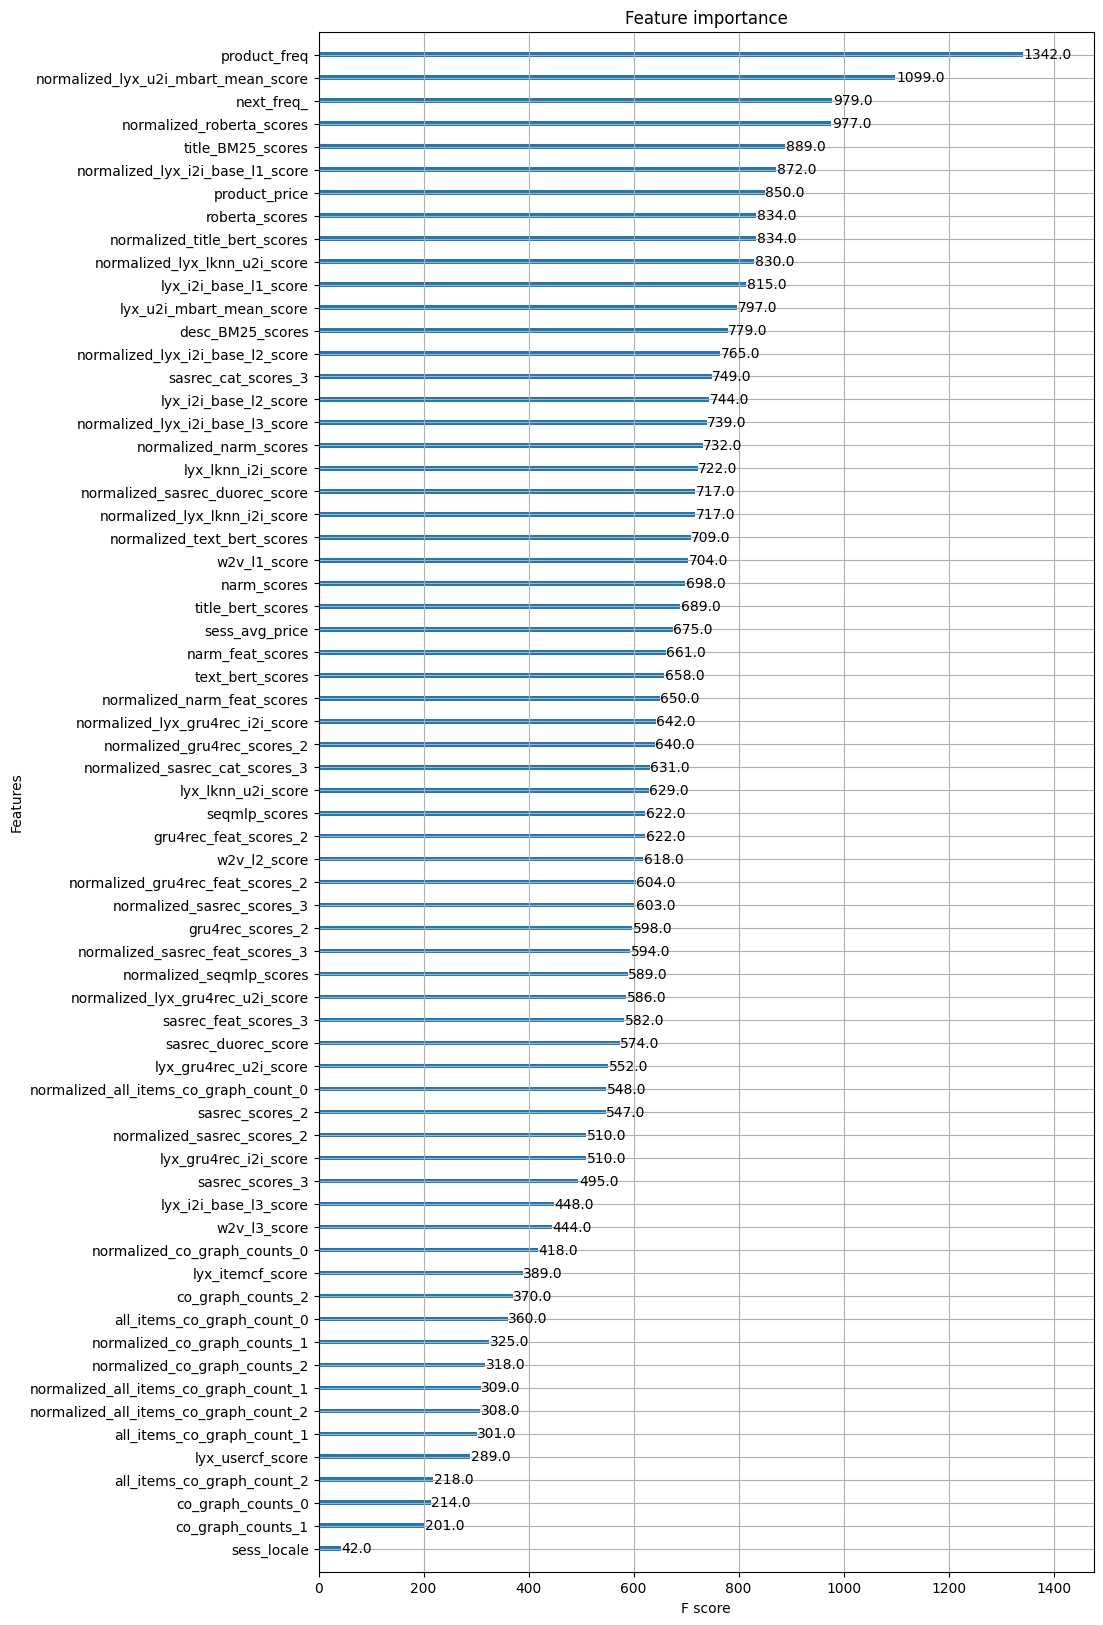

In [83]:
ax = xgb.plot_importance(model)
ax.figure.set_size_inches(10, 20)
plt.show()

In [23]:
test_candidates['next_freq_']

0             3.0
1            39.0
2           107.0
3             6.0
4            11.0
            ...  
96556030      0.0
96556031      1.0
96556032      9.0
96556033      4.0
96556034      7.0
Name: next_freq_, Length: 96556035, dtype: float32

In [ ]:
test_candidates['product_freq']

0             11.0
1            125.0
2           1103.0
3             25.0
4             52.0
             ...  
96556030       4.0
96556031       5.0
96556032      45.0
96556033      23.0
96556034      24.0
Name: product_freq, Length: 96556035, dtype: float32

In [28]:
test_candidates['next_freq']

0            3.0
1           30.0
2           57.0
3            5.0
4            9.0
            ... 
96556030     0.0
96556031     1.0
96556032     8.0
96556033     2.0
96556034     6.0
Name: next_freq, Length: 96556035, dtype: float32

In [29]:
test_candidates['next_freq_']

0             3.0
1            39.0
2           107.0
3             6.0
4            11.0
            ...  
96556030      0.0
96556031      1.0
96556032      9.0
96556033      4.0
96556034      7.0
Name: next_freq_, Length: 96556035, dtype: float32

In [57]:
# verify gru4rec scores
candidates[candidates['sess_id'] == 250052].sort_values(by=['all_items_co_graph_count_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_all_items_co_graph_count_2', 'all_items_co_graph_count_2']].iloc[:50]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_all_items_co_graph_count_2,all_items_co_graph_count_2
75310714,UK,B086RKQX31,2.624353e-05,10.640163,0.142857,5
75310808,UK,B09JFK6TSG,3.837457e-06,8.717554,0.057143,2
75310639,UK,B0736W5XNB,9.567715e-01,21.144064,0.057143,2
75310666,UK,B07J4RPWCM,2.894120e-07,6.132840,0.028571,1
75310811,UK,B09KHGHZGB,1.496599e-04,12.381109,0.028571,1
75310713,UK,B086RK2D9D,3.524666e-07,6.329945,0.028571,1
75310645,UK,B075VXSWJG,2.157713e-08,3.536623,0.028571,1
75310716,UK,B088FBT2KV,2.140622e-04,12.739011,0.028571,1
75310856,UK,B09YJ8M8DN,8.450939e-09,2.599266,0.028571,1
75310603,UK,B00R3Z49G6,6.657788e-07,6.965946,0.028571,1


In [60]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 250052].sort_values(by=['all_items_co_graph_count_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_all_items_co_graph_count_2', 'all_items_co_graph_count_2']].iloc[:50]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_all_items_co_graph_count_2,all_items_co_graph_count_2
76112112,UK,B09R19452X,7.045467e-01,18.747795,0.092308,6
76112095,UK,B09NLSGKQY,2.322294e-01,17.637966,0.092308,6
76111921,UK,B079VZSC8R,9.280825e-03,14.418191,0.076923,5
76112152,UK,B0B9GC1QLH,5.079791e-09,0.000000,0.061538,4
76112163,UK,B0BFPD3HFQ,3.041778e-03,13.302683,0.046154,3
76111937,UK,B07JLZ38TK,1.436854e-03,12.552696,0.046154,3
76111885,UK,B00DB1HXNW,1.421892e-03,12.542229,0.030769,2
76111973,UK,B084BNW2PW,3.244701e-03,13.367264,0.030769,2
76112081,UK,B09GW4MZHZ,7.113118e-04,11.849596,0.030769,2
76112141,UK,B0B1BSDW8W,3.211836e-03,13.357083,0.030769,2


In [39]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 150032].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_gru4rec_scores_2', 'gru4rec_scores_2']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_gru4rec_scores_2,gru4rec_scores_2
45410538,JP,B00D4I3RQE,0.149126,17.879353,0.175603,16.938869
45410489,JP,B006CQUMI6,0.137605,17.798954,0.048113,15.644196
45410561,JP,B00LIS5OTU,0.100575,17.485470,0.061075,15.882751
45410517,JP,B0091GJZA0,0.099371,17.473425,0.146275,16.756132
45410563,JP,B00LIS5TZE,0.079887,17.255173,0.038087,15.410515
45410672,JP,B07T9ZPM7J,0.056772,16.913614,0.023711,14.936587
45410671,JP,B07T46Y55W,0.050035,16.787277,0.037382,15.391848
45410494,JP,B006CQVELU,0.045869,16.700344,0.071903,16.045969
45410490,JP,B006CQUMUO,0.043309,16.642916,0.021996,14.861488
45410516,JP,B008JGUVOC,0.042844,16.632122,0.086083,16.225962


In [25]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 150002].sort_values(by=['narm_scores'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_narm_scores', 'narm_scores']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_narm_scores,narm_scores
45401586,JP,B09NBSBMMY,0.778949,19.885757,0.742870,21.292591
45401541,JP,B08Z15DWMQ,0.060368,17.328272,0.091634,19.199871
45401623,JP,B0B1HVVJKP,0.006695,15.129188,0.021880,17.767664
45401582,JP,B09NBQQ492,0.003185,14.386286,0.012551,17.211887
45401593,JP,B09PYGCTDZ,0.008169,15.328185,0.010580,17.041069
45401636,JP,B0B6F9WW4W,0.001504,13.635960,0.010183,17.002754
45401637,JP,B0B6H7YFZK,0.009707,15.500629,0.009705,16.954704
45401514,JP,B0855VJ4PG,0.002875,14.283862,0.009394,16.922176
45401622,JP,B0B1HVFTRG,0.007881,15.292270,0.007036,16.633097
45401566,JP,B09G9Y83T3,0.009559,15.485256,0.007030,16.632198


In [48]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 50002].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'sess_avg_price', 'product_price']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,sess_avg_price,product_price
15012764,DE,B01MZIBJHT,0.964333,17.545765,8.445,36.240002
15012916,DE,B09297QJKV,0.012449,13.195959,8.445,8.890000
15012718,DE,B002Q1BH3K,0.009770,12.953611,8.445,7.480000
15012740,DE,B00QDCL4CW,0.008417,12.804597,8.445,230.240005
15012871,DE,B08HR4D3Q7,0.002450,11.570552,8.445,24.950001
15012928,DE,B097GHM25G,0.001071,10.743021,8.445,30.990000
15012964,DE,B09VHWWSD4,0.000295,9.452239,8.445,799.989990
15012943,DE,B09G64XKWT,0.000217,9.147932,8.445,8.000000
15012847,DE,B08CZXQH9B,0.000105,8.419291,8.445,329.000000
15012897,DE,B08T1TYDXL,0.000103,8.401633,8.445,189.990005


In [61]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 150013].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_co_graph_counts_2', 'co_graph_counts_2']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_co_graph_counts_2,co_graph_counts_2
45405097,JP,B09Q8SFVPY,0.419675,15.116422,0.277311,33.0
45405016,JP,B07LF84D5H,0.316771,14.835120,0.344538,41.0
45404869,JP,B00F437FKQ,0.081453,13.476970,0.109244,13.0
45404870,JP,B00F437GKK,0.074688,13.390257,0.033613,4.0
45404964,JP,B01MR4F8K3,0.016849,11.901218,0.025210,3.0
45404945,JP,B018VO4BPG,0.009728,11.351994,0.033613,4.0
45405000,JP,B07D86YRM2,0.009138,11.289371,0.008403,1.0
45405029,JP,B083Q9N2TS,0.006362,10.927288,0.008403,1.0
45405053,JP,B08TNNPG1F,0.004854,10.656667,0.000000,0.0
45404831,JP,B005UJ1FFA,0.004057,10.477363,0.016807,2.0


In [ ]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 250013].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_gru4rec_scores_2', 'gru4rec_scores_2']].iloc[:15]

In [ ]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 150002].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_gru4rec_scores_2', 'gru4rec_scores_2']].iloc[:15]

In [70]:
# verify gru4rec scores
candidates[candidates['sess_id'] == 50021].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_roberta_scores', 'roberta_scores']].iloc[:15]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_roberta_scores,roberta_scores
14930402,DE,B0933HYY8N,0.548652,19.150976,0.008795,281.700409
14930477,DE,B09XY2YJKX,0.125988,17.679695,0.007486,281.539307
14930401,DE,B0933HVCK5,0.087602,17.316311,0.008795,281.700409
14930390,DE,B08MQQ1567,0.074737,17.157482,0.050220,283.442688
14930388,DE,B08MQLFJDW,0.059612,16.931368,0.014220,282.180939
14930389,DE,B08MQMTYHB,0.022340,15.949873,0.044135,283.313507
14930437,DE,B09JWM8FG8,0.017162,15.686186,0.095558,284.085999
14930478,DE,B09XY3LXCB,0.016911,15.671474,0.028888,282.889679
14930450,DE,B09RSYCPZB,0.016810,15.665488,0.047642,283.389984
14930479,DE,B09XY45GCG,0.010719,15.215500,0.007486,281.539307


In [82]:
# verify gru4rec scores
test_candidates[test_candidates['sess_id'] == 251036].sort_values(by=['sasrec_scores_2'], ascending=False)[['sess_locale', 'product', 'normalized_sasrec_scores_2', 'sasrec_scores_2', 'normalized_text_bert_scores', 'text_bert_scores']].iloc[:50]

,sess_locale,product,normalized_sasrec_scores_2,sasrec_scores_2,normalized_text_bert_scores,text_bert_scores
76411461,UK,B099JXBWN5,9.994345e-01,17.675999,3.297880e-01,439.645660
76411300,UK,B008YETL18,1.795076e-04,9.051271,1.695834e-06,427.467621
76411399,UK,B08BCT42Q4,1.216746e-04,8.662404,1.226866e-06,427.143921
76411438,UK,B0922KKF6D,1.050585e-04,8.515572,3.137818e-03,434.990723
76411420,UK,B08QMM3WPL,3.575017e-05,7.437609,2.072464e-02,436.878540
76411436,UK,B0922HQGFL,3.334917e-05,7.368087,5.012355e-03,435.459106
76411494,UK,B09PRPL81D,1.349261e-05,6.463196,1.980957e-05,429.925598
76411367,UK,B07R8WVBRP,1.294363e-05,6.421658,1.718655e-05,429.783569
76411335,UK,B0792KWV77,1.000814e-05,6.164453,8.075192e-08,424.423065
76411305,UK,B00H7ZELTC,8.015149e-06,5.942387,1.452732e-05,429.615479
